### Cargar librerias 

In [7]:
import torch
from torchvision import datasets,transforms
import helper
import matplotlib.pyplot as plt

### Cargar conjunto de datos 

In [8]:
# definiir una transformacion 
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                            ])
# descargar conjunto de entrenamiento 
trainset=datasets.FashionMNIST('-/.pytorch/F_MNIST_data/',download=True,train=True,transform=transform)
## train (bool, optional) – If True, creates dataset from training.pt, otherwise from test.pt.
trainloader=torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
# descargar conjunto de prueba (test)
testset=datasets.FashionMNIST('-/.pytorch/F_MNIST_data/',download=True,train=False,transform=transform)
## train (bool, optional) – If True, creates dataset from training.pt, otherwise from test.pt.
testloader=torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)

In [3]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: -/.pytorch/F_MNIST_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

El numero de clases es 10


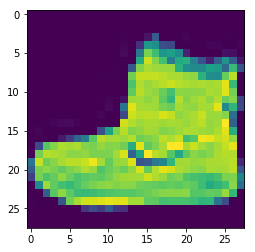

In [30]:
trainset.train_data.shape # existen 6000 imagenes de 28x28
img1=trainset.train_data[0]
plt.imshow(img1) 
n_clases=len(torch.unique(trainset.train_labels))
print("El numero de clases es",n_clases) 

### Mostrar imagen de entrenamiento 

torch.Size([64, 1, 28, 28])
torch.Size([64])


torch.Size([64, 784])

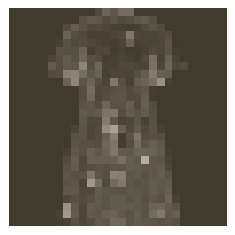

In [32]:
images,labels=next(iter(trainloader))
print(images.shape)
print(labels.shape)
helper.imshow(images[0,:])
x=images.view(images.shape[0],-1)
x.shape

### Construir red

Agregar caracterisitica de drop out , al hacer esto se necesitan utiliar los metodos .eval() 

In [9]:
from torch import nn,optim
import torch.nn.functional as F

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(784,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,64)
        self.fc4=nn.Linear(64,10)
        # agregar capa de dropout con probabilidad de 0.2
        self.dropout=nn.Dropout(p=0.2)
        
    def forward(self,x): # x tiene la forma 64 X 1 X 28 X 28
        x=x.view(x.shape[0],-1) # 64 x 748 
        
        # agregar dropout
        
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.dropout(F.relu(self.fc3(x)))
        
        # no se necesita dropout aqui 
        x=F.log_softmax(self.fc4(x),dim=1) # log(softmax(x))
        return x
    
    

### Entrenar red 

In [4]:
model=Net()  # crear una instacnia de la clase
model

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [5]:
criterion=nn.NLLLoss() # definir funcion de costo

In [6]:
optimizer=optim.Adam(model.parameters(),lr=0.003)  # definir optimizador 
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.003
    weight_decay: 0
)

In [15]:
epochs=3
steps=0

train_losses,test_losses=[],[]

for e in range(epochs):
    running_loss=0
    train_accuracy=0
    for images,labels in trainloader:
        log_ps=model(images) ## or model.forward(images)
        loss=criterion(log_ps,labels)
        optimizer.zero_grad()  ## limpiar optimizador (acumulado)
        loss.backward() # calcular gradientes
        optimizer.step() # actualizar parametros 
        running_loss  += loss.item()
        
        ps=torch.exp(log_ps)
        top_p,top_class=ps.topk(1,dim=1)  # obtenemos los maximos de la clasificacion
        
        equals=top_class==labels.view(*top_class.shape)
        train_accuracy=torch.mean(equals.type(torch.FloatTensor))
        
        
        
        
    else:  ## una vez que ya se hayan operado todos lo lotes de las imagenes de entrenamiento
        test_loss=0
        test_accuracy=0
        # apagar gradientes para validacion
        with torch.no_grad():
            model.eval() # establecer en modo evaluacion de esta forma , el dropout tambien se desactiva
            for images,labels in testloader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                
                
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)  # obtenemos los maximos de la clasificacion
                equals=top_class==labels.view(*top_class.shape)
                test_accuracy=torch.mean(equals.type(torch.FloatTensor))
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
                
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Train Accuracy: {:.3f}".format(train_accuracy/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(test_accuracy/len(testloader)))
        

Epoch: 1/3..  Training Loss: 0.431..  Train Accuracy: 0.001 Test Loss: 0.421..  Test Accuracy: 0.004
Epoch: 2/3..  Training Loss: 0.420..  Train Accuracy: 0.001 Test Loss: 0.399..  Test Accuracy: 0.006
Epoch: 3/3..  Training Loss: 0.412..  Train Accuracy: 0.001 Test Loss: 0.404..  Test Accuracy: 0.006


In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt


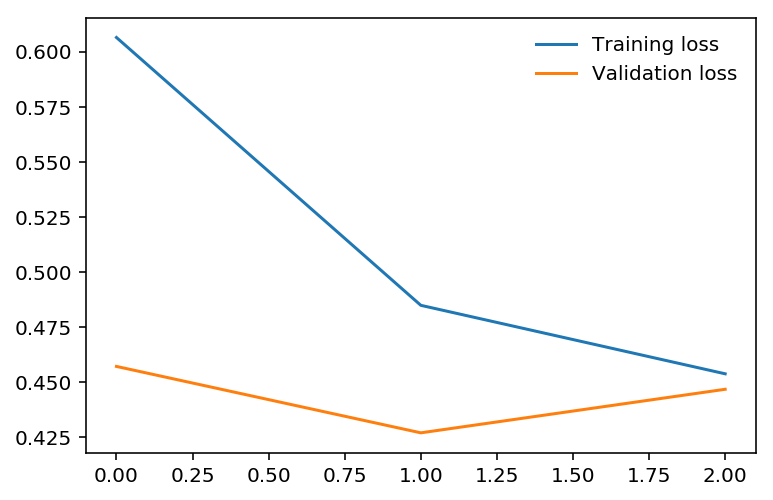

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Probar red

In [16]:
import helper

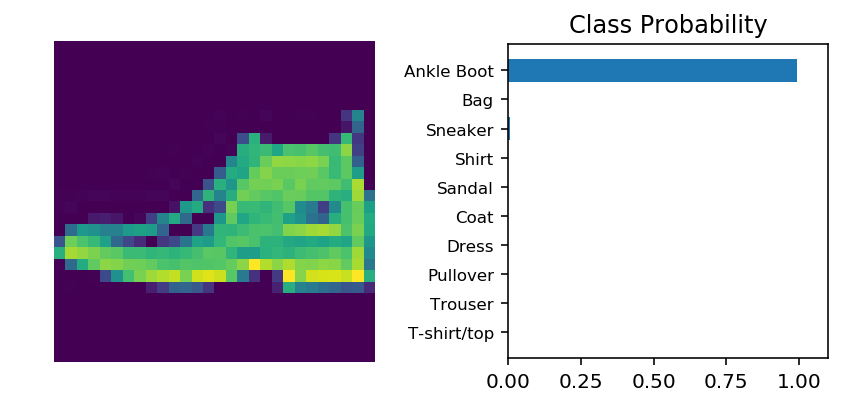

In [36]:
images,labels=next(iter(testloader))
img=images[0]

model.eval()
with torch.no_grad():
    ps=torch.exp(model(img)) # se utiliza exp debido a que la salida de la red regresa log

helper.view_classify(img,ps,version='Fashion')

### Salvar modelo

In [41]:
print("El modelo es: \n\n", model,'\n')
for x, y in thisdict.items():print(model.state_dict().keys()) ## model.state_dict() es simplemente un diccionario

El modelo es: 

 Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [78]:
arquitectura =[(x,*y.shape) for x,y in model.state_dict().items()]
checkpoint ={'architecture':arquitectura,
            'state_dict':model.state_dict()}
torch.save(checkpoint,'checkpoint.pth')
checkpoint

{'architecture': [('fc1.weight', 256, 784),
  ('fc1.bias', 256),
  ('fc2.weight', 128, 256),
  ('fc2.bias', 128),
  ('fc3.weight', 64, 128),
  ('fc3.bias', 64),
  ('fc4.weight', 10, 64),
  ('fc4.bias', 10)],
 'state_dict': OrderedDict([('fc1.weight',
               tensor([[ 0.1627,  0.1251,  0.0979,  ...,  0.1854,  0.1368,  0.1274],
                       [ 0.0140,  0.0205,  0.0277,  ...,  0.0412,  0.0688,  0.0024],
                       [ 0.0171,  0.0211,  0.0596,  ..., -0.0023,  0.0289,  0.0619],
                       ...,
                       [ 0.0834,  0.0846,  0.0171,  ...,  0.0298,  0.0643,  0.1004],
                       [ 0.1508,  0.1505,  0.1451,  ...,  0.1549,  0.1626,  0.1668],
                       [ 0.2063,  0.1641,  0.2125,  ...,  0.2164,  0.2311,  0.1780]])),
              ('fc1.bias',
               tensor([-0.1532, -0.0661, -0.0104, -0.2076, -0.0469, -0.0402, -0.2213, -0.0756,
                       -0.0929, -0.1459, -0.1208, -0.0973, -0.1039, -0.1041, -0.0484, 

### cargar modelo

In [79]:
model2=torch.load('checkpoint.pth')
model2

{'architecture': [('fc1.weight', 256, 784),
  ('fc1.bias', 256),
  ('fc2.weight', 128, 256),
  ('fc2.bias', 128),
  ('fc3.weight', 64, 128),
  ('fc3.bias', 64),
  ('fc4.weight', 10, 64),
  ('fc4.bias', 10)],
 'state_dict': OrderedDict([('fc1.weight',
               tensor([[ 0.1627,  0.1251,  0.0979,  ...,  0.1854,  0.1368,  0.1274],
                       [ 0.0140,  0.0205,  0.0277,  ...,  0.0412,  0.0688,  0.0024],
                       [ 0.0171,  0.0211,  0.0596,  ..., -0.0023,  0.0289,  0.0619],
                       ...,
                       [ 0.0834,  0.0846,  0.0171,  ...,  0.0298,  0.0643,  0.1004],
                       [ 0.1508,  0.1505,  0.1451,  ...,  0.1549,  0.1626,  0.1668],
                       [ 0.2063,  0.1641,  0.2125,  ...,  0.2164,  0.2311,  0.1780]])),
              ('fc1.bias',
               tensor([-0.1532, -0.0661, -0.0104, -0.2076, -0.0469, -0.0402, -0.2213, -0.0756,
                       -0.0929, -0.1459, -0.1208, -0.0973, -0.1039, -0.1041, -0.0484, 